<a href="https://colab.research.google.com/github/tomollow/Feel-and-Think/blob/main/%E8%87%AA%E5%B7%B1%E7%AC%A6%E5%8F%B7%E5%8C%96%E5%99%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# データの変換と正規化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNISTデータセットのロード
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# 確認
next(iter(train_loader))[0].shape


100%|██████████| 9912422/9912422 [00:00<00:00, 88634531.90it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 51701107.05it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26333713.08it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8675104.17it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([128, 1, 28, 28])

Epoch [1/10], Loss: 0.2258
Epoch [2/10], Loss: 0.1250
Epoch [3/10], Loss: 0.1138
Epoch [4/10], Loss: 0.1099
Epoch [5/10], Loss: 0.1080
Epoch [6/10], Loss: 0.1067
Epoch [7/10], Loss: 0.1055
Epoch [8/10], Loss: 0.1045
Epoch [9/10], Loss: 0.1035
Epoch [10/10], Loss: 0.1025


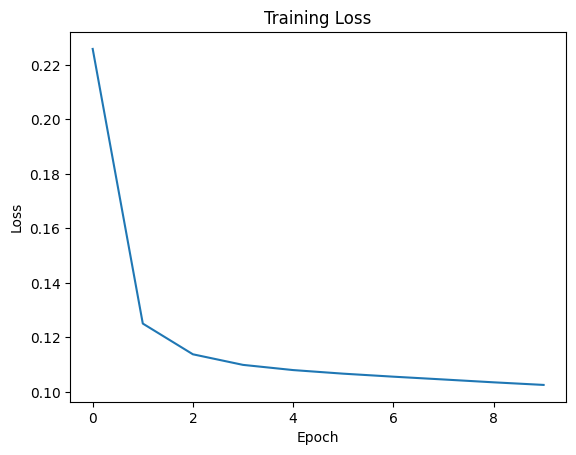

In [7]:
# 自己符号化器の定義
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # エンコーダ
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 32),
            nn.ReLU(),
            #nn.Linear(128, 64),
            #nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU()
        )
        # デコーダ
        self.decoder = nn.Sequential(
            nn.Linear(32, 32),
            #nn.ReLU(),
            #nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(32, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 自己符号化器のモデルを再構築
model = Autoencoder()

# 損失関数と最適化手法の再定義
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練関数の再定義
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        epoch_losses = []
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(data.size(0), -1)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        train_losses.append(np.mean(epoch_losses))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}")

    return train_losses

# モデルの訓練
num_epochs = 10
train_losses = train(model, train_loader, criterion, optimizer, num_epochs)

# 訓練の損失をプロット
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


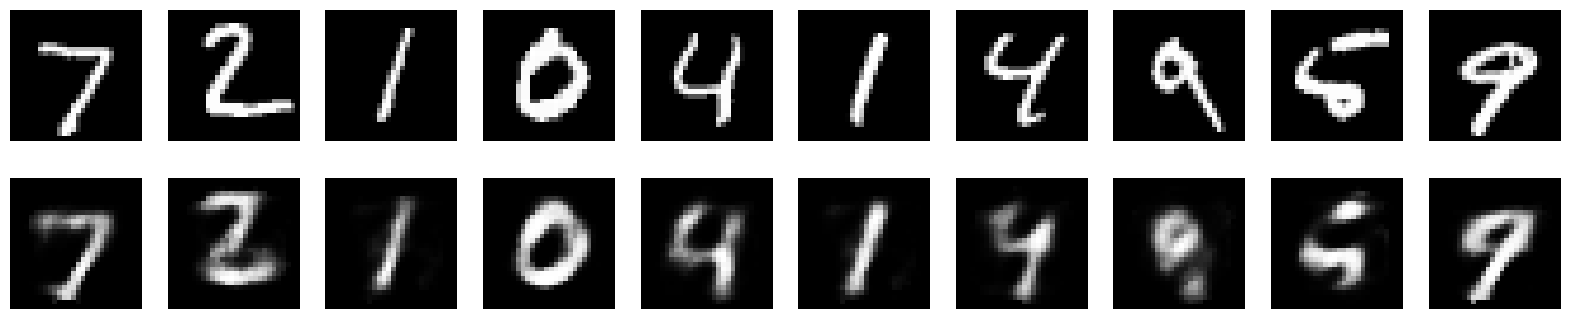

In [8]:
# モデルの評価関数の定義
def evaluate(model, test_loader):
    model.eval()
    reconstructed_images = []
    original_images = []
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(test_loader):
            data = data.view(data.size(0), -1)
            outputs = model(data)
            reconstructed_images.append(outputs.view(outputs.size(0), 28, 28))
            original_images.append(data.view(data.size(0), 28, 28))
            if batch_idx == 0:
                break  # 1バッチ分のデータのみ評価

    return original_images[0], reconstructed_images[0]

# モデルの評価と画像の再構築
original_imgs, reconstructed_imgs = evaluate(model, test_loader)

# 元の画像と再構築された画像を並べて表示
n = 10  # 表示する画像の数
plt.figure(figsize=(20, 4))

for i in range(n):
    # 元の画像
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_imgs[i].reshape(28, 28).detach().numpy(), cmap='gray')
    ax.axis('off')

    # 再構築された画像
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(28, 28).detach().numpy(), cmap='gray')
    ax.axis('off')

plt.show()
